# Displaying Music Notation In Azure Notebooks

There are several ways of creating an environment that allows Jupyter notebooks to display music notation, although some of them can be quite fiddly to set up from scratch if they even work at all.

This notebook is a work in progress exploring various ways of rendering musical notation within Jupyter notebooks...

This notebook also includes examples of packages for working with audio files generated from (representations of) musical scores.

On the to do list is see if I can recreate OERs such as the following OpenLEarn modules:

- [An introduction to music theory](http://www.open.edu/openlearn/history-the-arts/culture/music/introduction-music-theory/content-section-0?active-tab=content-tab)
- [Sound for music technology](http://www.open.edu/openlearn/science-maths-technology/engineering-and-technology/technology/sound-music-technology-introduction/content-section-0?active-tab=content-tab)

completely witin a notebook context.

## `music21`

`music21` is a comprehensive musicology toolkit capable of generating and analysing scores; getting the musical notation display to work can be a pain, although it is getting easier...

In [1]:
%%capture
try:
    import music21
except:
    !pip install music21

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [111]:
from music21 import *

#The extension seems to be a bit flaky at the moment
#The idea is that it makes it easy to embed scores, audio players etc
#The default midi audio player does not seem to respect instrument selection
%load_ext music21.ipython21

The music21.ipython21 extension is already loaded. To reload it, use:
  %reload_ext music21.ipython21


We can create musical constructions in a variety of ways, represented as computational objects we can then work with in a flexible way.

In [76]:
c = chord.Chord("C4 E4 G4")
c

<music21.chord.Chord C4 E4 G4>

For example, we can "display" the above chord as braille:

In [80]:
c.show('braille')

⠐⠳⠬⠔


Or we can write it as MusicXML:

In [85]:
xml = open(c.write('musicxml')).read()
xml

'<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE score-partwise  PUBLIC "-//Recordare//DTD MusicXML 3.0 Partwise//EN" "http://www.musicxml.org/dtds/partwise.dtd">\n<score-partwise version="3.0">\n  <movement-title />\n  <identification>\n    <creator type="composer" />\n    <encoding>\n      <encoding-date>2018-08-30</encoding-date>\n      <software>music21 v.5.3.0</software>\n    </encoding>\n  </identification>\n  <defaults>\n    <scaling>\n      <millimeters>7</millimeters>\n      <tenths>40</tenths>\n    </scaling>\n  </defaults>\n  <part-list>\n    <score-part id="P7b48989876380b955f5411ece3d96dd2">\n      <part-name />\n    </score-part>\n  </part-list>\n  <!--=========================== Part 1 ===========================-->\n  <part id="P7b48989876380b955f5411ece3d96dd2">\n    <!--========================= Measure 1 ==========================-->\n    <measure number="1">\n      <attributes>\n        <divisions>10080</divisions>\n        <time>\n          <beats>1</beats>\n    

To render scores, `music21` defaults to using `lilypond`, which will be demonstrated later in the notebook (it requires the installation of the `lilypond` application). However, work is currently ongoing to support display scores directly in notebooks using a javascript renderer. The following code is an early preview of that development (i.e. things should get smoother as the code is hopefully integrated into `music21`):

In [6]:
#Viewing music - via https://github.com/cuthbertLab/music21/issues/306 ?
from IPython.core.display import display, HTML, Javascript
import json, random
def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)
    
def showMusicXML(xml):
    DIV_ID = "OSMD-div-"+str(random.randint(0,1000000))
    #print("DIV_ID", DIV_ID)
    msg='loading OpenSheetMusicDisplay'
    msg=''
    display(HTML('<div id="'+DIV_ID+'">{}</div>'.format(msg)))
    
    #print('xml length:', len(xml))

    script = """
    console.log("loadOSMD()");
    function loadOSMD() { 
        return new Promise(function(resolve, reject){

            if (window.opensheetmusicdisplay) {
                console.log("already loaded")
                return resolve(window.opensheetmusicdisplay)
            }
            console.log("loading osmd for the first time")
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object 
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.3.1/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                console.log("loaded OSMD for the first time",opensheetmusicdisplay)
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        }) 
    }
    loadOSMD().then((OSMD)=>{
        console.log("loaded OSMD",OSMD)
        var div_id = "{{DIV_ID}}";
            console.log(div_id)
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id);
        openSheetMusicDisplay
            .load({{data}})
            .then(
              function() {
                console.log("rendering data")
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('{{DIV_ID}}',DIV_ID).replace('{{data}}',json.dumps(xml))
    display(Javascript(script))
    return DIV_ID


In [87]:
#The clutter comes from the score-part ID in the MusicXML file?
showScore(c)

<IPython.core.display.Javascript object>

### Tiny Notation

*Tiny notation* is a lightweight notation for getting scores into a `music21` representation:

In [21]:
from music21 import converter
s = converter.parse('tinyNotation: 4/4 C4 D4 E4 F4 G4 A4 B4 c4')
#This creates a stream of a single part
#Add an instrument to the part
s.insert(0, instrument.Guitar())

In [22]:
showScore(s)

<IPython.core.display.Javascript object>

### Playing a score

We can generate a playable midi file from a score and embed a player that allows us to listen to it.

In [23]:
#Intermittent issue here? Sometomes notebook gets in a state where this doesnlt render the player?
#Fix - empty cells, close notebook, reopen?
#Doesn't respect the instrument?
s.show('midi')

Several graphical analysis views are also available.

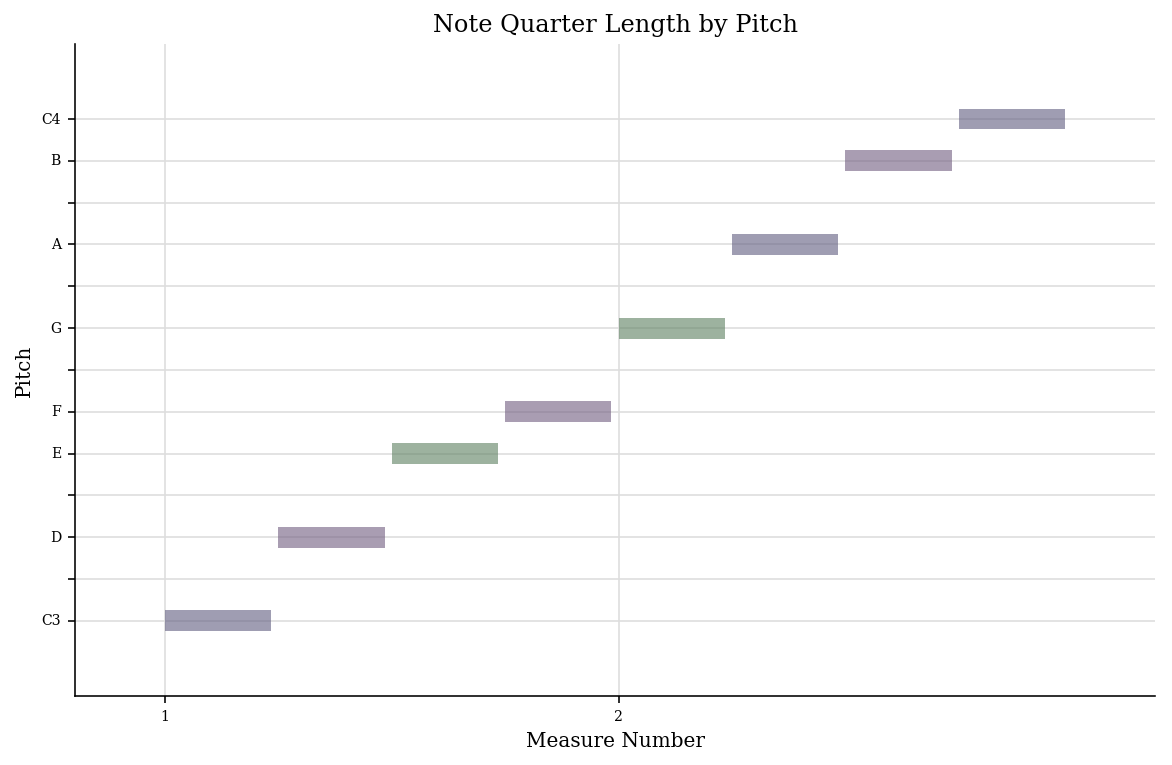

In [48]:
s.plot()

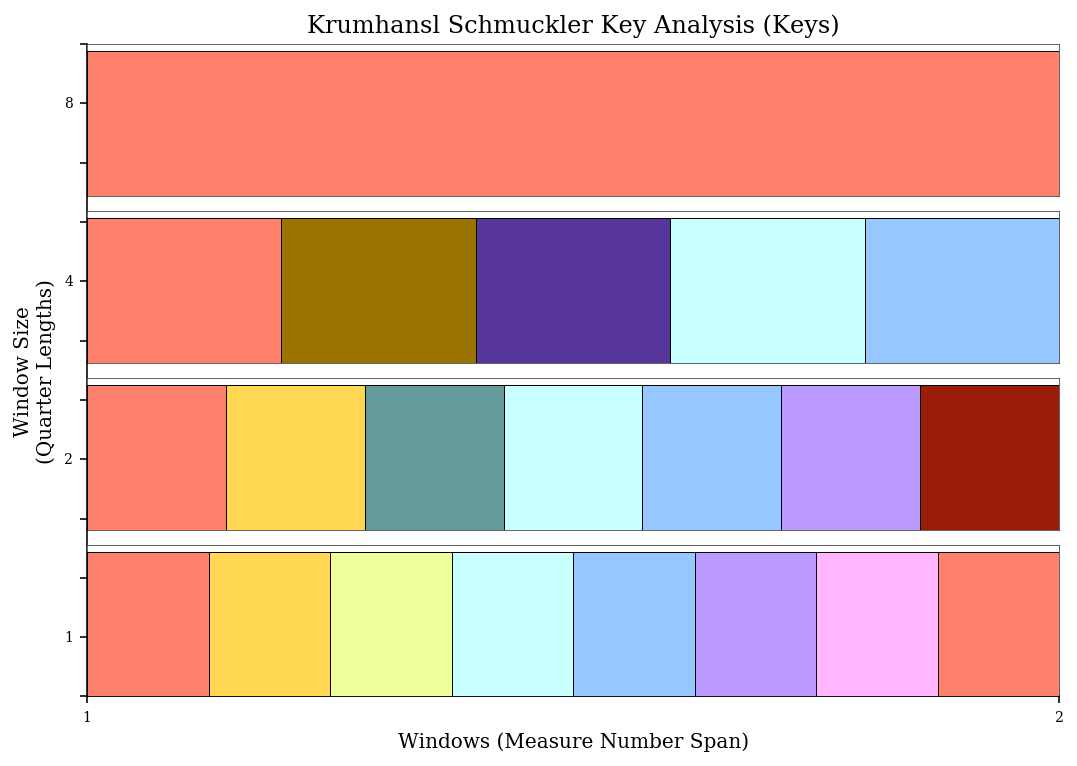

In [49]:
s.plot('key')

### Full Score Example

The `music21` package includes several complete scores. We can select one randomly, render the notation and play an audio version of it.

In [107]:
#https://github.com/cuthbertLab/music21/issues/306

import random
selected_piece = random.choice(corpus.getPaths())
print('loading piece', selected_piece)
score = corpus.parse(selected_piece)
score

loading piece /home/nbuser/anaconda3_501/lib/python3.6/site-packages/music21/corpus/ryansMammoth/UpAndWaurThemAWillieStrathspey.abc


<music21.stream.Score 0x7f4c0f3c7e48>

In [108]:
showScore(score)

<IPython.core.display.Javascript object>

In [109]:
score.show('midi')

### Searching for Scores in the `music21` Corpora

One of the advantages of using `music21` is that it bundles bundles a large corpus of musical scores. We can search through these scores to find a piece of music that we can then use within the notebook.

For example, we can search by composer:

In [60]:
a=[c for c in corpus.search('carolan', 'composer')]
a[0].metadata.all()

[('ambitus',
  "AmbitusShort(semitones=17, diatonic='P4', pitchLowest='G4', pitchHighest='C6')"),
 ('composer', "O'Carolan"),
 ('keySignatureFirst', '<music21.key.KeySignature of 1 sharp>'),
 ('keySignatures', "['<music21.key.KeySignature of 1 sharp>']"),
 ('noteCount', '167'),
 ('number', '661'),
 ('numberOfParts', '1'),
 ('pitchHighest', 'C6'),
 ('pitchLowest', 'G4'),
 ('quarterLength', '144.0'),
 ('timeSignatureFirst', '3/4'),
 ('timeSignatures', "['3/4']"),
 ('title', 'Planxty Dobbins')]

Searches return a metadata bundle, which cas also be search within by chaining the search queries:

In [91]:
c = corpus.search('carolan', 'composer').search('Princess Royal', 'title')
c

<music21.metadata.bundles.MetadataBundle {1 entry}>

In [100]:
#We can now parse the score and start to work with it
showScore(c[0].parse())

<IPython.core.display.Javascript object>

In [93]:
c[0].show('midi')

When discussing a particular piece, we may want to focus on particular parts of it. We can reference into particular measures and just focus on those. For example:

In [105]:
showScore(c[0].parse().measures(0,4))

<IPython.core.display.Javascript object>

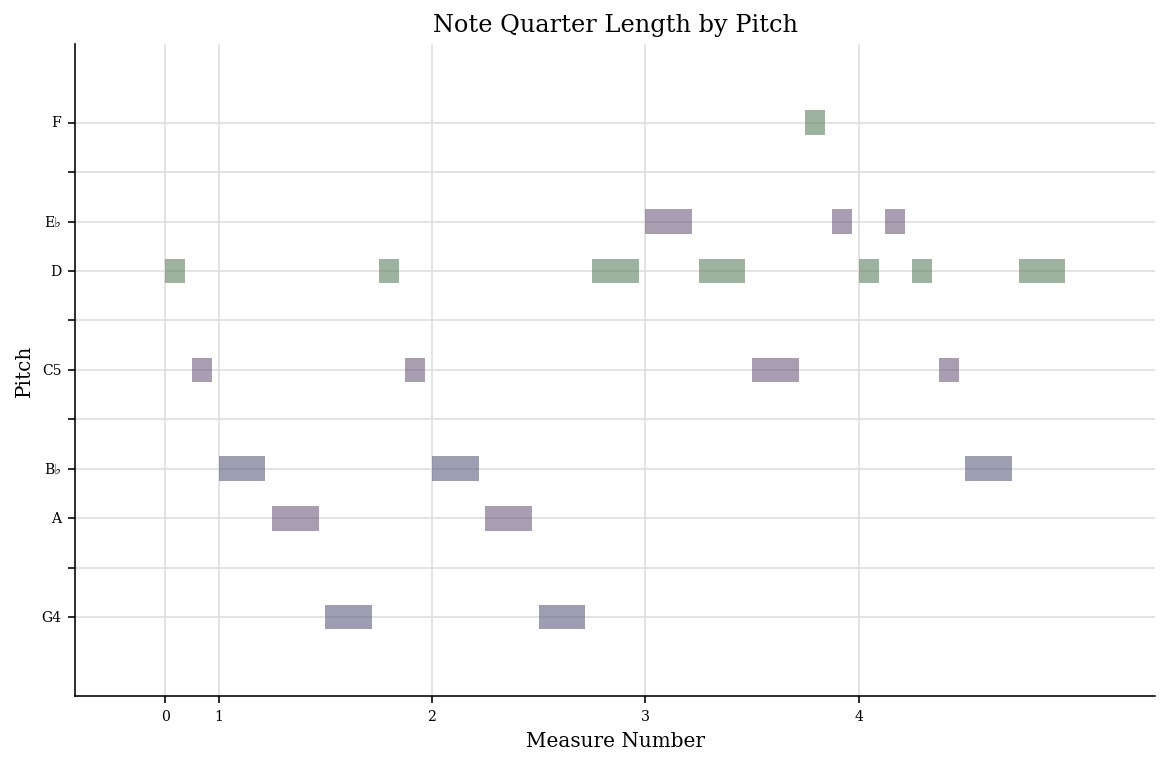

In [102]:
c[0].parse().measures(0,4).plot()

It's easy enough to just listen to particular measures:

In [104]:
c[0].parse().measures(0,2).show('midi')

## lilypond

`Lilypond` is a pwerful framework for creating sheet music. See http://lilybin.com/ for a handy online editor.

In [ ]:
%%capture

import os
cwd = os.getcwd()

if cwd == '/home/nbuser/library':
    #Azure notebook maybe?
    #Install lilypond - used to render notation
    ! wget http://lilypond.org/download/binaries/linux-64/lilypond-2.18.2-1.linux-64.sh
    #then for forced (no prompts) install:
    !sh lilypond-2.18.2-1.linux-64.sh --batch
    #
    #Making /home/nbuser/lilypond
    #Making /home/nbuser/bin
    #Creating script /home/nbuser/bin/lilypond
    #Creating script /home/nbuser/bin/lilypond-wrapper.python
    #Creating script /home/nbuser/bin/lilypond-wrapper.guile
    #Creating script /home/nbuser/bin/uninstall-lilypond
    #To uninstall lilypond, run
    # !    /home/nbuser/bin/uninstall-lilypond
    LILYPOND_PATH = '/home/nbuser/bin/lilypond'

In [ ]:
import os
from IPython.display import Image

def lp(score):
    score='''\version "2.18.2"
    \header {{ 
    tagline = ""  % removed 
    }} {}'''.format(score)
    with open("test.ly", "w") as out_file:
        out_file.write(score)
    os.system( "{} -dbackend=eps -dno-gs-load-fonts -dinclude-eps-fonts --png test.ly".format(LILYPOND_PATH) )
    return Image(filename='test.png')

In [ ]:
empty=r'''
#(set-global-staff-size 20)

\score {
  {
    \repeat unfold 2 { s1 \break }
  }
  \layout {
    indent = 0\in
    \context {
      \Staff
      \remove "Time_signature_engraver"
      \remove "Clef_engraver"
      \remove "Bar_engraver"
    }
    \context {
      \Score
      \remove "Bar_number_engraver"
    }
  }
}

'''

try:
    lp(empty)
except:
    pass

In [ ]:
#Some handy layout hints here: http://lilypond.org/doc/v2.19/Documentation/snippets/paper-and-layout

#### Using `lilypond` with `music21`

A wide range of examples can be picked up from the [MusicXML test suite](http://web.mit.edu/music21/doc/developerReference/musicxmlTest.html).

In [ ]:
#The setting of environment variables and the display of notation is borked on Linux
#Use crappy workarounds for now - or perhaps try a conda install?


from music21 import *


import os
cwd = os.getcwd()

#Hacky test
if cwd == "/home/jovyan":
    #Binderhub maybe?
    environment.UserSettings()['lilypondPath']='/usr/bin/lilypond'
    environment.set('pdfPath', '/usr/bin/musescore')
    environment.set('graphicsPath', '/usr/bin/musescore')
    environment.set("musescoreDirectPNGPath", "/usr/bin/musescore")
    environment.set("musicxmlPath", "/usr/bin/musescore")   
elif cwd == '/home/nbuser/library':
    #Azure notebook maybe?
    environment.UserSettings()['lilypondPath']= LILYPOND_PATH
    
%load_ext music21.ipython21

from IPython.display import Image

def render(s):
    s.show('lily.png')
    return Image(filename=str(s.write('lily.png')))

In [ ]:
from IPython.display import Image


def render(s):
    #s.show('lily.png')
    return Image(filename=str(s.write(fmt='lily.png')))

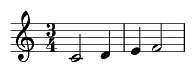

In [49]:
noteC = note.Note("C4", type="half")
noteD = note.Note("D4", type="quarter")
noteE = note.Note("E4", type="quarter")
noteF = note.Note("F4", type="half")

tsThreeFour = meter.TimeSignature('3/4')

stream1 = stream.Stream()

for thisThing in [tsThreeFour, noteC, noteD, noteE, noteF]:
    stream1.append(thisThing)

render(stream1)
#native display requires musescore to be installed using default setups...
#stream1.show()

In [77]:
#Can we render using vexflow?
#HTML is rendered but assets don't load - need new template?
#from IPython.display import display, HTML, IFrame 
#display(HTML(vexflow.toMusic21j.fromObject(stream1).replace('http:','https:'),200,200))

In [50]:
def tiny(t):
    return render( converter.parse('tinyNotation: {}'.format(t)) )

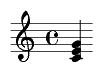

In [51]:
c = chord.Chord("C4 E4 G4")
c.isConsonant()
render(c)

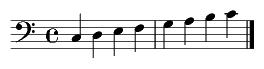

In [52]:
from music21 import converter
s = converter.parse('tinyNotation: 4/4 C4 D4 E4 F4 G4 A4 B4 c4')
render(s)

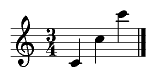

In [53]:
tiny("3/4 c4 c'4 c''4")

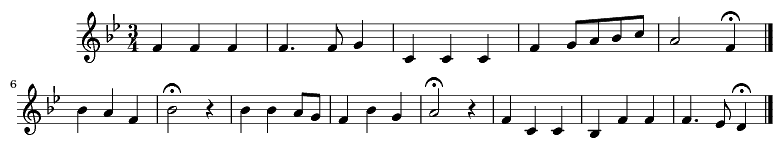

In [54]:
myBach = corpus.parse('bach/bwv57.8')
alto = myBach.parts['Alto']

render(alto)

In [ ]:
#music21 .write() formats - http://web.mit.edu/music21/doc/moduleReference/moduleCommonFormats.html

In [ ]:
#see also: https://www.python-course.eu/python_scores.php

In [122]:
#Guitar tablature in music21
fn1 = tablature.FretNote(string=3, fret=2, fingering=1)
fn2 = tablature.FretNote(string=2, fret=3, fingering=3)
fn3 = tablature.FretNote(string=1, fret=2, fingering=2)
fb = tablature.FretBoard(6, fretNotes=[fn1, fn2, fn3], displayFrets=5)
#How do we display this?
#render(fb)

### Rendering scale tables from `music21`

Via https://iacchus.github.io/jupyter-notebooks/html/music21-scale-tables-013.html


In [7]:
%%capture
try:
    import svgwrite
except:
    ! pip3.6 install svgwrite

In [8]:
from IPython.display import display, HTML #, Image, Audio
#import plim
import base64
#from music21.common.pathTools import relativepath as m21_jupyter_relpath
from PIL import Image as PILImage
import svgwrite as sw
import seaborn

In [27]:
def returnScale(tonic='c', mode='major', ownKey=False):
    
    modes = [ 'ionian','dorian','phrygian',
              'lydian','mixolydian','aeolian',
              'locrian','major','minor']
    
    if not mode in modes: mode = 'major'
        
    if mode == 'ionian': mode = 'major'
    if mode == 'aeolian': mode = 'minor'

    tonic_pitch = pitch.Pitch(tonic)
    scale_sharps = key.pitchToSharps(tonic_pitch, mode)

    scale_func = getattr(scale, "{0}Scale".format(mode.capitalize()))
    real_scale = scale_func(tonic_pitch)
    pitches = real_scale.getPitches()

    scale_name = real_scale.name
    absolute_intervals = []
    relative_intervals = []
    note_names = []
    myKeySig = key.KeySignature(scale_sharps)
    
    mystream = stream.Stream()
    
    if ownKey:
        mystream.append(myKeySig)

    for idx,cur_pitch in enumerate(pitches):
        mynote = note.Note(cur_pitch)

        cur_degree = real_scale.getScaleDegreeFromPitch(cur_pitch)
        past_degree_or_tonic = cur_degree-1 if cur_degree>1 else 1
        
        absolute_interval = real_scale.intervalBetweenDegrees(1,cur_degree).name
        #relative_interval_semitones = real_scale.intervalBetweenDegrees(past_degree_or_tonic, cur_degree).semitones
        try:
            relative_interval_semitones = interval.notesToChromatic(cur_pitch, pitches[idx+1]).semitones
        except:
            #pass
            relative_interval_semitones = 'None'
        #relative_interval = real_scale.intervalBetweenDegrees(past_degree_or_tonic, cur_degree).name
        
        absolute_intervals.append(absolute_interval)
        relative_intervals.append(relative_interval_semitones)
        note_names.append(cur_pitch.unicodeName)
        #mynote.addLyric(absolute_interval)
        #mynote.addLyric(relative_interval_semitones)
        
        mystream.append(mynote)
        
    filename = mystream.write(fmt='lily.png')
        
    return {
        'scalename': scale_name,
        'stream' : mystream,
        'filename': filename,
        'ai' : absolute_intervals,
        'ri' : relative_intervals,
        'nn' : note_names,
    }

In [28]:
def svg_table2(sc):
    #print(sc)
    img_w, img_h = PILImage.open(sc['filename']).size

    with open(sc['filename'],'rb') as image_file:
        b64_scale = base64.b64encode(image_file.read()).decode('utf8')
        image_data = "data:image/png;base64,{}".format(b64_scale)

    def y_by_line(line_num, line_height):
        return (line_num-1) * line_height

    svg_attrs = {
        'font-family': 'Inconsolata, monospace',
    #    'shape-rendering':'optimizeQuality',

    }

    title_text_attrs = {
        'fill':'#fff',
        'alignment-baseline' : 'middle',
        'text-anchor' : 'middle',
        'font-weight' : 'bold',
    }

    image_attrs = {
        'stroke' : '#666',
    }
    img_rect_attrs = {
        'fill':'none',
        'stroke':'#000',
        'stroke-width':'1',
    }

    background_attrs = {
        'stroke':'#000',
        'fill':'#fff',
        'stroke-width':'1',
    }

    title_attrs = {
        'color': '#fff',
        'fill':'#336',
        'stroke':'#000',
        'stroke-width':'1',
    }

    cell_rect_attrs = {
        'fill':'#fff',
        'stroke':'#666',
        'stroke-width':'1',
    }
    cell_path_attrs = {
        'fill':'none',
        'stroke':'#000',
        'stroke-width':'1',
    }
    cell_text_attrs = {
        #'fill':'#fff',
        #'stroke':'#333',
        #'stroke-width':'1',
        'alignment-baseline' : 'middle',
        'text-anchor' : 'middle',
        'font-weight' : 'bold',
    }
    # sizes in px

    #line_height = 32

    #table_width = 440
    table_width = img_w
    line_height = img_h/3

    table_height = line_height*7

    cell_width = table_width/8

    # SVG

    dwg = sw.Drawing(profile='full', size=("{}".format(table_width),"{}".format(table_height)), **svg_attrs)

    # BACKGROUND

    # why not beutiful background right now;
    background = sw.shapes.Rect(insert=(0,0), size=(table_width, table_height), **background_attrs)
    dwg.add(background)

    # TITLE
    
    cell_group = sw.container.Group()

    group_els = [
        sw.shapes.Rect(insert=(0,0), size=(table_width, line_height), **title_attrs),
        sw.text.Text(sc['scalename'], insert=(table_width/2, line_height/2), **title_text_attrs)
    ]

    for element in group_els:
        cell_group.add(element)

    dwg.add(cell_group)

    # IMAGE

    table_image = sw.image.Image(href=image_data, insert=(0,line_height), size=(img_w, img_h))
    dwg.add(table_image)
    #array = [1,2,3,4,5,6,7,8]
    #array2 = ["I","II","III","IV","V","VI","VII","VIII"]
    cell_group = sw.container.Group()

    group_els = [
        sw.image.Image(href=image_data, insert=(0,line_height), size=(img_w, img_h)),
        sw.shapes.Rect(insert=(0,line_height), size=(img_w, img_h), **img_rect_attrs),
    ]

    for element in group_els:
        cell_group.add(element)

    dwg.add(cell_group)
    
    # ABSOLUTE

    for idx,item in enumerate(sc['ai']):

        x = idx * cell_width
        y = y_by_line(line_num=5, line_height=line_height)

        v_center = (line_height/2) + y
        h_center = (cell_width/2) + x

        cell_group = sw.container.Group()

        group_els = [
            sw.shapes.Rect(insert=(x, y), size=(cell_width, line_height), **cell_rect_attrs),
            sw.text.Text(item, insert=(h_center, v_center), **cell_text_attrs)
        ]

        for element in group_els:
            cell_group.add(element)

        dwg.add(cell_group)

    # NOTE NAMES
    for idx,item in enumerate(sc['nn']):

        x = idx * cell_width
        y = y_by_line(line_num=6, line_height=line_height)

        v_center = (line_height/2) + y
        h_center = (cell_width/2) + x

        cell_group = sw.container.Group()

        group_els = [
            sw.shapes.Rect(insert=(x, y), size=(cell_width, line_height), **cell_rect_attrs),
            sw.text.Text(item, insert=(h_center, v_center), **cell_text_attrs)
        ]

        for element in group_els:
            cell_group.add(element)

        dwg.add(cell_group)
        
    # INTERVALS
    for idx,item in enumerate(sc['ri']):
        v_center = (line_height/2) + idx * y_by_line(line_num=7, line_height=line_height)
        h_center = (cell_width/2) + y_by_line(line_num=7, line_height=line_height)

        x = idx * cell_width + (cell_width/2)
        y = y_by_line(line_num=7, line_height=line_height) + (line_height/2)
        
        path_h_pad = cell_width /10
        path_width = cell_width - path_h_pad
        path_height = (line_height/3)
        path_v_pad = -(path_height/2)
        cell_group = sw.container.Group()
        
        # minor second
        if item == 1:
            path_commands = [
                'M{0} {1}'.format(x,y-path_height/2),
                'l {0} {1}'.format(path_width/2, path_height),
                'l {0} -{1}'.format(path_width/2, path_height),
            ]


        # major second
        elif item == 2:
            path_commands = [
                'M{0} {1}'.format(x,y-path_height/2),
                'v {0}'.format(path_height),
                'h {0}'.format(path_width),
                'v -{0}'.format(path_height),
            ]
            
        group_els = [
            sw.path.Path(d=path_commands, **cell_path_attrs),
            #sw.shapes.Rect(insert=(x, y), size=(cell_width, line_height), **cell_rect_attrs),
            #sw.text.Text(item, insert=(x, y), **cell_text_attrs)
        ]

        for element in group_els:
            cell_group.add(element)

        dwg.add(cell_group)

    # returns <svg/> table:
    return dwg.tostring()

{'scalename': 'G mixolydian', 'stream': <music21.stream.Stream 0x7f88a5d1fc50>, 'filename': PosixPath('/tmp/music21/tmpipn3y_om.ly.png'), 'ai': ['P1', 'M2', 'M3', 'P4', 'P5', 'M6', 'm7', 'P1'], 'ri': [2, 2, 1, 2, 2, 1, 2, 'None'], 'nn': ['G', 'A', 'B', 'C', 'D', 'E', 'F', 'G']}



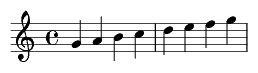
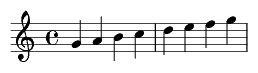

In [36]:
sc = returnScale('g','mixolydian')
svg_img = svg_table2(sc)
display(HTML(svg_img))

## `abjad`

[requires py3.6] https://github.com/Abjad/abjad

In [17]:
#Provide a path to the lilypond executable
import os
os.environ["PATH"] += os.pathsep + '/'.join([]+LILYPOND_PATH.split('/')[:-1])

In [ ]:
%%capture
try:
    import abjad
except:
    #Imagemagick required for rendering, along with lilypond
    ! conda install -y -c conda-forge imagemagick
    ! pip3.6 install abjad
    ! pip3.6 install abjad[ipython]

In [18]:
import abjad
#Need to set path in /home/nbuser/.abjad/abjad.cfg 
# Change is from lilypond_path = lilypond to lilypond_path = /home/nbuser/bin/lilypond
# Can do this from terminal using nano; really need to do a sed CLI for it here...
#That said, it doesn't seem to be picked from the config file in the ipython previewer?

In [ ]:
import abjadext.ipython
show = abjadext.ipython.Show()
abjad.show = show

In [19]:
duration = abjad.Duration(1, 4)
notes = [abjad.Note(pitch, duration) for pitch in range(8)]
staff = abjad.Staff(notes)

In [ ]:
abjad.show(staff)

In [20]:
abjscore = abjad.persist(staff).as_midi()
abjscore

('/home/nbuser/.abjad/output/0010.midi',
 0.015712261199951172,
 1.3133385181427002,
 True)

In [22]:
#abjad uses timidity to play audio files in a notebook
#But we can play the midi file without timidity via music21?
#Load in the midi file
s2=converter.parse(abjscore[0])
#showScore(s2)
s2.show('midi')

## `librosa`

Audio package

In [ ]:
%%capture
try:
    import librosa
except:
    !pip install librosa
%matplotlib inline

In [ ]:
import librosa

filename = librosa.util.example_audio_file()
x, sr = librosa.load(filename)

In [ ]:
#some great example / tutorial files at: https://musicinformationretrieval.com/index.html

In [ ]:
#https://musicinformationretrieval.com/feature_sonification.html
from IPython.display import Audio

Audio(x, rate=sr)

In [ ]:
import librosa.display

librosa.display.waveplot(x);

In [ ]:
import librosa, librosa.display
import numpy as np

X = librosa.stft(x)
Xmag = librosa.amplitude_to_db(np.abs(X))

librosa.display.specshow(Xmag, sr=sr, x_axis='time', y_axis='log');

## `pysoundfile`
Read soundfiles.

In [ ]:
try:
    import soundfile
except:
    !conda install -y -c conda-forge pysoundfile 

## To Chase - Other Music notation displays / players

In [ ]:
#to explore:
#https://iacchus.github.io/jupyter-notebooks/html/music21-scale-tables-013.html
#https://jupyter.brynmawr.edu/services/public/dblank/jupyter.cs/Sonification.ipynb
#https://github.com/CoderLine/alphaTab

In [ ]:
#https://wiki.python.org/moin/PythonInMusic

In [ ]:
#Other possible ways of displaying music21 scores?
#How about s/thing like:
# - music21j - js reinterpetation of music21, uses vexflow
# - http://www.vexflow.com/
# - https://opensheetmusicdisplay.org/ - DEMO ABOVE
# - https://www.verovio.org/javascript.xhtml
# - https://abcjs.net/
# - http://dezrann.net/demo/index.html http://dezrann.net/dev/
# - https://github.com/danigb/tonal
# - http://freetomik.github.io/
# - https://github.com/SymphoniaIO/web-musicxml-editor

In [ ]:
#http://web.mit.edu/music21/doc/moduleReference/moduleVexflowToMusic21j.html

#http://tenor-conference.org/proceedings/2018/14_Giraud_tenor18.pdf - DEZRANN

In [ ]:
#music oer https://github.com/hybrid-pedagogy/openmusictheory

## *abc notation*

A simpler approach looks like it may be to use [abc notation](http://abcnotation.com/) (using [abcjs](https://github.com/paulrosen/abcjs)).

However, the Jupyter notebook extension to support `abcjs` doesn't currently work on notebooks.azure.com (it seems to be fine in other notebook environments). Keep checking back here and I'll post a working version as soon as I can find one...

*Azure notebook experimental features need disabling: [abc.js issue](https://github.com/akaihola/jupyter_abc/issues/2)*? STILL DOESN"T WORK...

In [1]:
%%capture
#Install an extension to render music written in abc notation
try:
    %load_ext jupyter_abc
except:
    !pip install git+https://github.com/akaihola/jupyter_abc.git

In [2]:
#Load the required extension
%load_ext jupyter_abc

Now we should be able to write some *abc* code and render a score.

In [3]:
%%abc
%%score (R1 R2) (L)
V:R1
[cc']2 z ((3g/a/b/ [cc']2) z ((3g/a/b/ | [cc']2) z2 z2 z c | (c3 B d3 c) | (g4 f2) z2 |
V:R2
x8 | x8 | G8- | G6 z2 |
V:L clef=bass middle=d
[cc']2 z ((3g/a/b/ [cc']2) z ((3g/a/b/ | [cc']2) z2 z4 | ([d'f']4 [c'e']4) | [bd']6 z2 |

<IPython.core.display.Javascript object>

## *LaTeX*

There are several `LaTeX` packages that can support the display of musical notation (for example, [`musictex`](https://ctan.org/pkg/musictex?lang=en) and [`abc`](https://ctan.org/pkg/abc?lang=en)). However, at the current time, they do not appear to be supported in Azure notebooks.

This may be useful? https://martin-thoma.com/how-to-write-music-with-latex/

In [1]:
#Check latex paths
#!kpsepath tex

.:/home/nbuser/.texmf-config/tex/kpsewhich//:/home/nbuser/.texmf-var/tex/kpsewhich//:/home/nbuser/texmf/tex/kpsewhich//:/etc/texmf/tex/kpsewhich//:!!/var/lib/texmf/tex/kpsewhich//:!!/usr/local/share/texmf/tex/kpsewhich//:!!/usr/share/texmf/tex/kpsewhich//:!!/usr/share/texlive/texmf-dist/tex/kpsewhich//:/home/nbuser/.texmf-config/tex/generic//:/home/nbuser/.texmf-var/tex/generic//:/home/nbuser/texmf/tex/generic//:/etc/texmf/tex/generic//:!!/var/lib/texmf/tex/generic//:!!/usr/local/share/texmf/tex/generic//:!!/usr/share/texmf/tex/generic//:!!/usr/share/texlive/texmf-dist/tex/generic//:/home/nbuser/.texmf-config/tex///:/home/nbuser/.texmf-var/tex///:/home/nbuser/texmf/tex///:/etc/texmf/tex///:!!/var/lib/texmf/tex///:!!/usr/local/share/texmf/tex///:!!/usr/share/texmf/tex///:!!/usr/share/texlive/texmf-dist/tex///


In [3]:
%%capture
try:
    %load_ext tikz_magic
except:
    !conda install -y imagemagick
    !pip install --user git+https://github.com/innovationOUtside/ipython_magic_tikz

In [5]:
%load_ext tikz_magic

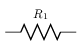

In [8]:
%%tikz -p circuitikz -s 0.3
    %This is just a test of something I know should work...
    %Draw a resistor labelled R_1 connecting points (0,0) and (2,0)
    \draw (0,0) to[R, l=$R_1$] (2,0);

In [25]:
#Identify if a package is available, and if so where it is...
!kpsewhich tikz

/usr/share/texlive/texmf-dist/tex/plain/pgf/frontendlayer/tikz.tex


In [41]:
#Set up texlive to install things as local user?
#!tlmgr init-usertree
#!tlmgr option repository ftp://tug.org/historic/systems/texlive/2015/tlnet-final
!tlmgr install abc
!tlmgr install musixtex

(running on Debian, switching to user mode!)
tlmgr: setting default package repository to ftp://tug.org/historic/systems/texlive/2015/tlnet-final
(running on Debian, switching to user mode!)
TeX Live 2015 is frozen forever and will no
longer be updated.  This happens in preparation for a new release.

If you're interested in helping to pretest the new release (when
pretests are available), please read http://tug.org/texlive/pretest.html.
Otherwise, just wait, and the new release will be ready in due time.
tlmgr: package repository ftp://tug.org/historic/systems/texlive/2015/tlnet-final
tlmgr install: package already present: abc
(running on Debian, switching to user mode!)
TeX Live 2015 is frozen forever and will no
longer be updated.  This happens in preparation for a new release.

If you're interested in helping to pretest the new release (when
pretests are available), please read http://tug.org/texlive/pretest.html.
Otherwise, just wait, and the new release will be ready in due time

In [42]:
#Still not there?
!kpsewhich abc

In [ ]:
%%tikz --no-wrap -p musixtex
%Seems like musixtex not avaliable?
\begin{document}
    \noindent This is a clef:
    \begin{music}\trebleclef\end{music}
\end{document}

In [ ]:
%%tikz --no-wrap -p abc

\begin{document}
    You can create music sheets within the abc-environment:
    \begin{abc}[name=c-dur]
        X: 1 % start of header
        K: C % scale: C major
        "Text"c2 G4 | (3FED c4 G2 |
    \end{abc}
\end{document}

## Guitar Fretboards

In [ ]:
%%capture
try:
    #https://github.com/dmpayton/python-fretboard
    import fretboard
except:
    !pip install fretboard

In [2]:
import fretboard

!mkdir -p images

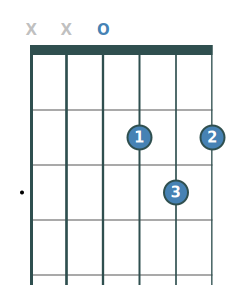

In [5]:
from IPython.display import SVG
chord = fretboard.Chord(positions='xx0232', fingers='---132')
chord.save('images/D.svg')
SVG('images/D.svg')

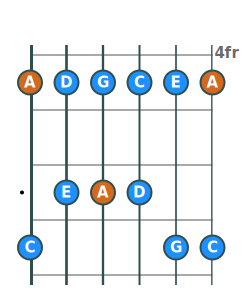

In [22]:
fb = fretboard.Fretboard(frets=(5, 8), style={'marker': {'color': 'dodgerblue'}})
fb.add_marker(string=0, fret=5, label='A', color='chocolate')
fb.add_marker(string=1, fret=5, label='D')
fb.add_marker(string=2, fret=5, label='G')
fb.add_marker(string=3, fret=5, label='C')
fb.add_marker(string=4, fret=5, label='E')
fb.add_marker(string=5, fret=5, label='A', color='chocolate')

fb.add_marker(string=0, fret=8, label='C')
fb.add_marker(string=1, fret=7, label='E')
fb.add_marker(string=2, fret=7, label='A', color='chocolate')
fb.add_marker(string=3, fret=7, label='D')
fb.add_marker(string=4, fret=8, label='G')
fb.add_marker(string=5, fret=8, label='C')

fn='images/pentatonic-shape.svg'
fb.save(fn)
SVG(fn)

In [77]:
#Rotate 90 - deosn't quite work? Image size issue?
#https://gist.github.com/mtherieau/85c30d764056fc8dd48c712554a5e261
import svgwrite

fret_numerals = [None, 'I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII', 'XVIII', 'XIX', 'XX']
def rotate_90counter_and_save(fb, filename):
    fb.draw()
    [e.__setattr__('text', str(fret_numerals[int(e.text[:-2])])) for e in fb.drawing.elements if isinstance(e, svgwrite.text.Text) and e.text.endswith('fr')]
    [e.rotate(angle=90, center=(e.attribs['x'], e.attribs['y'])) for e in fb.drawing.elements if isinstance(e, svgwrite.text.Text)]

    drawing = svgwrite.Drawing()
    group = drawing.g()
    drawing.add(group)
    for e in fb.drawing.elements:
        group.add(e)
        
    width = next((e.attribs['width'] for e in fb.drawing.elements if isinstance(e, svgwrite.shapes.Rect)), 0)
    #tx offset is x offset from margin
    #TH very hack  - need to properly fit to output cell size?
    group.translate(tx=0, ty=width-120)
    group.scale(0.5)
    group.rotate(angle=270)
    drawing.saveas(filename)
    
fn='images/gtrtabtest.svg'
rotate_90counter_and_save(fb, fn)
SVG(fn)